# Generate EMDB-IDs list

In [60]:
from ftplib import FTP

servername = "files.rcsb.org"
ftp = FTP(servername)
ftp.login(user='random_user',passwd='random_password')

subdir = "pub/emdb/structures"

try:
    entries_raw = ftp.nlst(subdir)

except ftplib.error_perm as resp:
    if str(resp) == "550 No files found":
        print("No files in this directory")
    else:
        raise

In [61]:
entries_cleaned = [x.split('/')[-1] for x in entries_raw if '.' not in x.split('/')[-1]]
emdb_entries = entries_cleaned

In [62]:
len(emdb_entries)

25227

# Get experimental annotations

In [63]:
import os
import numpy as np
import requests
import coloredlogs, logging
from time import process_time

In [64]:
# Configure logger
workdir = '/data/dragon000/sanjuan/oxford/cryodb' #os.path.dirname(trajectory_filepath)

coloredlogs.install(level='ERROR')
logging.basicConfig(level=logging.ERROR)
logging.basicConfig(filename=os.path.join(workdir,'emdb_annotations.log'),
                    filemode='w', 
                    format='%(name)s - %(levelname)s - %(message)s')

In [65]:
extract_data = lambda x:x['structure_determination_list']['structure_determination'][0]['specimen_preparation_list']['specimen_preparation'][0]

def retrieveInfoEMDB(emdb_id, url_prefix='https://www.ebi.ac.uk/emdb/api/entry/experiment/'):
    emdb_url = url_prefix + emdb_id
    respond = requests.get(url=emdb_url)
    
    if respond.status_code != 200:
        logging.error("request status %d" % (respond.status_code))
        raise DownloadException("Error, retrieveInfoFromEMDB request status %d" % (respond.status_code))
    
    else:
        data = respond.json()
    
    try:
        exptl_annotations = extract_data(data)
        return exptl_annotations
    
    except Exception as e:

        logger.error(e)
        return None

Iterate over index interval chunks

In [42]:
from operator import itemgetter

N = len(emdb_entries)
d = 100

index_intervals = [range(i*d,(i+1)*d) if (i+1)*d < N else range(i*d,N) for i in range(round(N/d))]

exptl_annotations = {}
for i in range(5):
    entries_interval = itemgetter(*index_intervals[i])(emdb_entries)
    try:
        annotations = {emdb_id:retrieveInfoEMDB(emdb_id) for emdb_id in entries_interval}
        exptl_annotations.update(annotations)
        
    except Exception as e:
        print(e)

In [71]:
exptl_annotations

{'EMD-0001': {'preparation_id': 1,
  'concentration': {'units': 'mg/mL', 'valueOf_': '0.5'},
  'buffer': {'ph': 8.0,
   'component': [{'concentration': {'units': 'mM', 'valueOf_': '10.0'},
     'formula': 'Tris-HCL',
     'name': 'Tris hydrochloride',
     'instance_type': 'component'},
    {'concentration': {'units': 'mM', 'valueOf_': '150.0'},
     'formula': 'NaCL',
     'name': 'sodium chloride',
     'instance_type': 'component'},
    {'concentration': {'units': 'mM', 'valueOf_': '10.0'},
     'formula': 'MgCl2',
     'name': 'magnesium chloride',
     'instance_type': 'component'}]},
  'grid': {'model': 'Quantifoil R1.2/1.3', 'material': 'COPPER'},
  'vitrification': {'cryogen_name': 'ETHANE',
   'chamber_humidity': {'units': 'percentage', 'valueOf_': '95'},
   'chamber_temperature': {'units': 'K', 'valueOf_': '277'},
   'instrument': 'FEI VITROBOT MARK IV'},
  'instance_type': 'single_particle_preparation'},
 'EMD-0002': {'preparation_id': 1,
  'concentration': {'units': 'mg/mL'

Save data

In [14]:
import pickle
with open('test_data.pickle', 'wb') as fp:
    pickle.dump(exptl_annotations, fp)

<span style='color:red'><b>ISSUE</b></span>
* Connection dies after certain number of requests (>300 entries)

```python
ConnectionError: HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-0348 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f9218e429d0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
```

# Pipeline Routine: Proof of concept

Gather list of EMDB entries

In [57]:
%%writefile pull_emdb_data.py 
import pickle
import numpy as np
from ftplib import FTP
from operator import itemgetter

import os
import numpy as np
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

import coloredlogs, logging
from time import process_time


def get_emdb_entries():
    servername = "files.rcsb.org"
    ftp = FTP(servername)
    ftp.login(user='random_user',passwd='random_password')

    subdir = "pub/emdb/structures"

    try:
        entries_raw = ftp.nlst(subdir)

    except ftplib.error_perm as resp:
        if str(resp) == "550 No files found":
            print("No files in this directory")
        else:
            raise

    entries_cleaned = [x.split('/')[-1] for x in entries_raw if '.' not in x.split('/')[-1]]
    emdb_entries = entries_cleaned
    
    return emdb_entries


def extract_data(x):
    data = {}
    for i, y in enumerate(x['structure_determination_list']['structure_determination']):
        data[i] = {}
        for j, z in enumerate(y['specimen_preparation_list']['specimen_preparation']):
            data[i][j] = z
    return data

def retrieveInfoEMDB(emdb_id, url_prefix='https://www.ebi.ac.uk/emdb/api/entry/experiment/'):
    #extract_data = lambda x:x['structure_determination_list']['structure_determination'][0]['specimen_preparation_list']['specimen_preparation'][0]
    
    emdb_url = url_prefix + emdb_id
    
    # set up session to allow retry 3 times
    # backoff_factor will help to apply delays between attempts
    # avoiding ConnectionError due to request quota
    session = requests.Session()
    retry = Retry(connect=3, backoff_factor=0.5)
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    
    respond = session.get(url=emdb_url)

    if respond.status_code != 200:
        logging.error("request status %d" % (respond.status_code))
        raise DownloadException("Error, retrieveInfoFromEMDB request status %d" % (respond.status_code))
    else:
        data = respond.json()
    
    try:
        exptl_annotations = extract_data(data)
        return exptl_annotations
    except Exception as e:
        logger.error(e)
        return None

def partition_range(N, num_partitions):
    partition_size = N // num_partitions
    partitions = [range(i * partition_size, (i + 1) * partition_size) for i in range(num_partitions - 1)]
    partitions.append(range((num_partitions - 1) * partition_size, N))
    
    return partitions

def get_exptl_annotations(emdb_entries, interval_length=100):
    N_entries = len(emdb_entries)
    num_partitions = int(N_entries/interval_length)
    index_intervals = partition_range(N_entries, num_partitions)

    exptl_annotations = {}
    for i in range(len(index_intervals)):
        entries_interval = itemgetter(*index_intervals[i])(emdb_entries)
        try:
            annotations = {emdb_id:retrieveInfoEMDB(emdb_id) for emdb_id in entries_interval}
            exptl_annotations.update(annotations)

        except Exception as e:
            print(e)
    
    return exptl_annotations

if __name__ == "__main__":
    emdb_entries = get_emdb_entries()
    exptl_annotations = get_exptl_annotations(emdb_entries[:len(emdb_entries)])

    with open('data/exptl_annotations_all_22-Feb-2023.pickle', 'wb') as fp:
        pickle.dump(exptl_annotations, fp)

Overwriting pull_emdb_data.py


In [2]:
emdb_entries = get_emdb_entries()

In [3]:
len(emdb_entries)

25227

**TEST** Donwload first 2000 entries from list

In [5]:
exptl_annotations = get_exptl_annotations(emdb_entries[:2000])

New protocol

* _TIME_ 2m 50s, 1000 
* _TIME_ 5m 38s, 2000


ESTIMATED TIME FOR ALL ENTRIES
* 1h 15m = 75.68m

In [7]:
import pickle
with open('data/exptl_annotations_test_22-Feb-2023.pickle', 'wb') as fp:
    pickle.dump(exptl_annotations, fp)

In [11]:
!cp data/exptl_annotations_test_22-Feb-2023.pickle test_data.pickle

In [48]:
!ls -lrth data/

total 5.2M
-rw------- 1 sanjuan acadrel 289K Jan 27 17:19 test_data_600-entries.pickle
-rw------- 1 sanjuan acadrel 2.0M Jan 30 10:58 exptl_annotations_test_30-Jan-2023.pickle
-rw------- 1 sanjuan acadrel 2.0M Jan 30 11:14 test_data.pickle
-rw------- 1 sanjuan acadrel 949K Feb 22 14:06 exptl_annotations_test_22-Feb-2023.pickle


Save data

In [26]:
import pickle

with open('test_data_600-entries.pickle', 'wb') as fp:
    pickle.dump(exptl_annotations, fp)

Estimate output filesize and gathering time

In [54]:
filesize = 949 # KB
N_entries = 25227
N_entries_test = 2000
all_expected_filesize = filesize*N_entries/(N_entries_test*1000) # MB
print(all_expected_filesize, 'MB')

11.9702115 MB


In [53]:
filetime = 5.5 # mins
N_entries_test = 2000
all_expected_filetime = filetime*N_entries/(N_entries_test) # mins
print(all_expected_filetime, 'minutes')

69.37425 minutes


# Evaluate scope of data availabilty

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pickle
filepath = 'data/exptl_annotations_all_22-Feb-2023.pickle'
with open(filepath, 'rb') as fp:
    exptl_annotations = pickle.load(fp)

In [3]:
len(exptl_annotations.keys())

24827

## Annotation Universe

In [4]:
import itertools

In [5]:
annotations_universe = set()
for emdb_id in exptl_annotations.keys():
    X = exptl_annotations[emdb_id]

    emdb_id_annotations = []
    for k1 in X.keys():
        annotations_lists = [list(X[k1][k2].keys()) for k2 in X[k1].keys()]
        annotations = list(itertools.chain.from_iterable(annotations_lists))
        emdb_id_annotations.append(annotations)

    emdb_id_annotations = set(itertools.chain.from_iterable(emdb_id_annotations))
    annotations_universe = annotations_universe.union(emdb_id_annotations)

In [6]:
annotations_universe

{'buffer',
 'concentration',
 'cryo_protectant',
 'crystal_formation',
 'details',
 'fiducial_markers_list',
 'grid',
 'high_pressure_freezing',
 'instance_type',
 'preparation_id',
 'sectioning',
 'staining',
 'sugar_embedding',
 'vitrification'}

In [7]:
len(annotations_universe)

14

## Number of annotations

In [29]:
# Number all annotations, including different preparations
X = exptl_annotations
n_annotations = {k1:[[len(X[k1][k2][k3].keys()) for k3 in X[k1][k2].keys()] for k2 in X[k1].keys()]  for k1 in X.keys()}
n_annotations = {k: np.sum(v) for k,v in n_annotations.items()}

In [30]:
# Number all annotations, taking first preparation id
X = exptl_annotations
n_annotations = {k1:len(X[k1][0][0].keys()) for k1 in X.keys()}

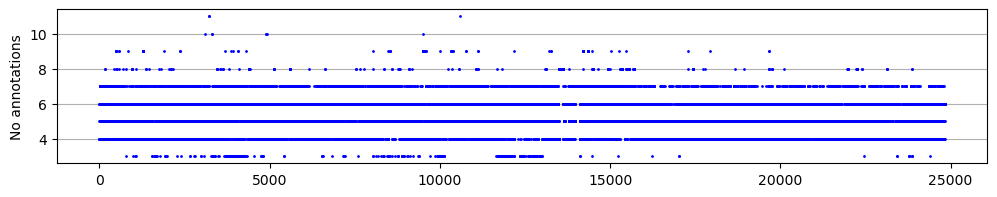

In [31]:
fig, ax = plt.subplots(1,1,figsize=(12,2),dpi=100)

ax.plot(n_annotations.values(),'bo',markersize=1)
ax.set_ylabel('No annotations')
ax.yaxis.grid(True)

plt.show()

In [32]:
set(n_annotations.values())

{3, 4, 5, 6, 7, 8, 9, 10, 11}

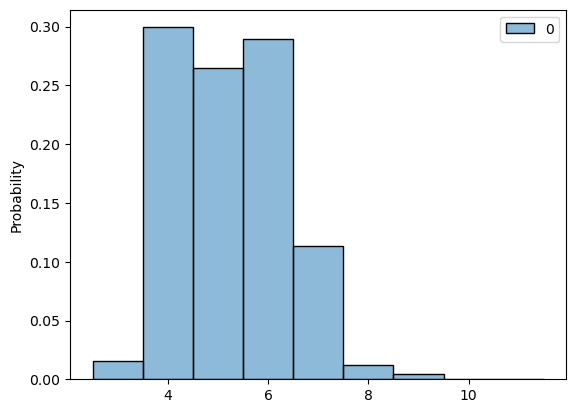

In [33]:
hist = sns.histplot(n_annotations.values(),
                    stat='probability',
                    discrete=True)


## Sample entries

Maximum number of annotations

In [34]:
for emdb_id in n_annotations.keys():
    if n_annotations[emdb_id] == 11:
        print(emdb_id)

EMD-12374
EMD-12376
EMD-3820


In [35]:
exptl_annotations['EMD-12104'][0][0]

{'preparation_id': 1,
 'buffer': {'ph': 7.0, 'details': 'MilliQ water was used.'},
 'staining': {'type_': 'NEGATIVE', 'material': 'Uranyl acetate'},
 'sugar_embedding': {'material': 'Lowicryl HM20',
  'details': 'High pressure frozen samples were freeze substituted in a Leica AFS'},
 'grid': {'model': 'Quantifoil R3.5/1',
  'material': 'GOLD',
  'mesh': 200,
  'pretreatment': {'type_': 'GLOW DISCHARGE'}},
 'details': 'Brain slices were high pressure frozen and freeze substituted',
 'fiducial_markers_list': {'fiducial_marker': [{'manufacturer': 'EMS',
    'diameter': {'units': 'nanometer', 'valueOf_': '10'},
    'instance_type': 'fiducial_marker'}]},
 'high_pressure_freezing': {'instrument': 'OTHER',
  'details': "Tissue sections were high-pressure frozen in 100 um deep wells of aluminium carriers in the presence of  bovine serum albumin using a Leica HPM100.. The value given for _emd_high_pressure_freezing.instrument is Leica HPM100. This is not in a list of allowed values {'EMS-002 RA

In [28]:
exptl_annotations['EMD-12104'][0][2]

{'preparation_id': 3,
 'concentration': {'units': 'mg/mL', 'valueOf_': '0.7'},
 'buffer': {'ph': 7.5,
  'component': [{'concentration': {'units': 'mM', 'valueOf_': '20.0'},
    'name': 'Hepes',
    'instance_type': 'component'},
   {'concentration': {'units': 'mM', 'valueOf_': '150.0'},
    'formula': 'NaCl',
    'name': 'sodium chloride',
    'instance_type': 'component'}]},
 'grid': {'model': 'Quantifoil R2/2',
  'material': 'COPPER',
  'mesh': 300,
  'support_film': [{'film_type_id': 1,
    'film_material': 'CARBON',
    'film_topology': 'HOLEY',
    'film_thickness': {'units': 'nm', 'valueOf_': '12.0'},
    'instance_type': 'support_film'}],
  'pretreatment': {'type_': 'GLOW DISCHARGE', 'atmosphere': 'AIR'}},
 'vitrification': {'cryogen_name': 'ETHANE',
  'chamber_humidity': {'units': 'percentage', 'valueOf_': '100'},
  'chamber_temperature': {'units': 'K', 'valueOf_': '277'},
  'instrument': 'FEI VITROBOT MARK IV',
  'details': '3 microliters of sample, blot force 0, 15 second wai

Minumum number of annotations

In [39]:
for emdb_id in n_annotations.keys():
    if n_annotations[emdb_id] == 4:
        print(emdb_id)

EMD-0004
EMD-0005
EMD-0006
EMD-0009
EMD-0011
EMD-0015
EMD-0016
EMD-0017
EMD-0018
EMD-0022
EMD-0026
EMD-0027
EMD-0028
EMD-0029
EMD-0030
EMD-0032
EMD-0033
EMD-0034
EMD-0035
EMD-0036
EMD-0037
EMD-0044
EMD-0045
EMD-0047
EMD-0048
EMD-0049
EMD-0055
EMD-0063
EMD-0064
EMD-0065
EMD-0076
EMD-0080
EMD-0081
EMD-0082
EMD-0083
EMD-0090
EMD-0091
EMD-0092
EMD-0096
EMD-0097
EMD-0098
EMD-0099
EMD-0100
EMD-0101
EMD-0102
EMD-0104
EMD-0105
EMD-0109
EMD-0110
EMD-0111
EMD-0112
EMD-0113
EMD-0133
EMD-0134
EMD-0144
EMD-0176
EMD-0177
EMD-0192
EMD-0193
EMD-0194
EMD-0195
EMD-0197
EMD-0201
EMD-0202
EMD-0203
EMD-0209
EMD-0210
EMD-0211
EMD-0212
EMD-0213
EMD-0214
EMD-0215
EMD-0216
EMD-0218
EMD-0219
EMD-0220
EMD-0221
EMD-0222
EMD-0223
EMD-0224
EMD-0225
EMD-0226
EMD-0227
EMD-0228
EMD-0229
EMD-0230
EMD-0231
EMD-0232
EMD-0233
EMD-0244
EMD-0245
EMD-0252
EMD-0261
EMD-0268
EMD-0269
EMD-0270
EMD-0277
EMD-0278
EMD-0281
EMD-0284
EMD-0285
EMD-0286
EMD-0287
EMD-0288
EMD-0294
EMD-0295
EMD-0296
EMD-0299
EMD-0300
EMD-0302
EMD-0304
E

In [40]:
exptl_annotations['EMD-0004']

{0: {0: {'preparation_id': 1,
   'buffer': {'ph': 7.4},
   'vitrification': {'cryogen_name': 'ETHANE'},
   'instance_type': 'single_particle_preparation'}}}

## Annotation categories

Determine category indentities

In [22]:
annotations_subsets = []
for emdb_id in exptl_annotations.keys():
    annotations = list(exptl_annotations[emdb_id].keys())
    annotations_subsets.append(annotations)

In [23]:
import itertools
annotations_subsets.sort()

annotations_categories = list(k for k,_ in itertools.groupby(annotations_subsets))

In [24]:
annotations_categories

[['preparation_id',
  'buffer',
  'details',
  'high_pressure_freezing',
  'cryo_protectant',
  'sectioning',
  'instance_type'],
 ['preparation_id',
  'buffer',
  'grid',
  'vitrification',
  'cryo_protectant',
  'sectioning',
  'instance_type'],
 ['preparation_id',
  'buffer',
  'grid',
  'vitrification',
  'details',
  'cryo_protectant',
  'sectioning',
  'instance_type'],
 ['preparation_id',
  'buffer',
  'grid',
  'vitrification',
  'details',
  'fiducial_markers_list',
  'cryo_protectant',
  'sectioning',
  'instance_type'],
 ['preparation_id',
  'buffer',
  'grid',
  'vitrification',
  'details',
  'fiducial_markers_list',
  'sectioning',
  'instance_type'],
 ['preparation_id',
  'buffer',
  'grid',
  'vitrification',
  'details',
  'instance_type'],
 ['preparation_id',
  'buffer',
  'grid',
  'vitrification',
  'details',
  'sectioning',
  'instance_type'],
 ['preparation_id',
  'buffer',
  'grid',
  'vitrification',
  'fiducial_markers_list',
  'cryo_protectant',
  'sectioning

In [25]:
len(annotations_categories)

68

Determine the entries split into these categories

In [94]:
import json

In [100]:
entries_by_category = {}
for category in annotations_categories:
    category_key = json.dumps(category)
    entries_by_category[category_key] = []
    for emdb_id in exptl_annotations.keys():
        annotations = set(exptl_annotations[emdb_id].keys())
        if annotations == set(category):
            entries_by_category[category_key].append(emdb_id)

In [101]:
entries_by_category

{'["preparation_id", "buffer", "grid", "vitrification", "details", "instance_type"]': ['EMD-0205',
  'EMD-0207',
  'EMD-0290',
  'EMD-0292',
  'EMD-0293',
  'EMD-0325'],
 '["preparation_id", "buffer", "grid", "vitrification", "instance_type"]': ['EMD-0031',
  'EMD-0043',
  'EMD-0061',
  'EMD-0062',
  'EMD-0070',
  'EMD-0107',
  'EMD-0137',
  'EMD-0138',
  'EMD-0139',
  'EMD-0149',
  'EMD-0150',
  'EMD-0164',
  'EMD-0165',
  'EMD-0167',
  'EMD-0168',
  'EMD-0169',
  'EMD-0170',
  'EMD-0175',
  'EMD-0198',
  'EMD-0262',
  'EMD-0263',
  'EMD-0274',
  'EMD-0348',
  'EMD-0349',
  'EMD-0350',
  'EMD-0359',
  'EMD-0360',
  'EMD-0361',
  'EMD-0363',
  'EMD-0364',
  'EMD-0365',
  'EMD-0366',
  'EMD-0369',
  'EMD-0370',
  'EMD-0371',
  'EMD-0373',
  'EMD-0374',
  'EMD-0379',
  'EMD-0380',
  'EMD-0381',
  'EMD-0383',
  'EMD-0386',
  'EMD-0387',
  'EMD-0388',
  'EMD-0390'],
 '["preparation_id", "buffer", "staining", "grid", "details", "instance_type"]': ['EMD-0324'],
 '["preparation_id", "buffer",

In [110]:
for key in entries_by_category.keys():
    print(len(entries_by_category[key]), key, len(json.loads(key)))

6 ["preparation_id", "buffer", "grid", "vitrification", "details", "instance_type"] 6
45 ["preparation_id", "buffer", "grid", "vitrification", "instance_type"] 5
1 ["preparation_id", "buffer", "staining", "grid", "details", "instance_type"] 6
1 ["preparation_id", "buffer", "staining", "grid", "instance_type"] 5
1 ["preparation_id", "buffer", "vitrification", "details", "fiducial_markers_list", "sectioning", "instance_type"] 7
2 ["preparation_id", "buffer", "vitrification", "details", "instance_type"] 5
2 ["preparation_id", "buffer", "vitrification", "fiducial_markers_list", "sectioning", "instance_type"] 6
94 ["preparation_id", "buffer", "vitrification", "instance_type"] 4
29 ["preparation_id", "concentration", "buffer", "grid", "vitrification", "details", "instance_type"] 7
53 ["preparation_id", "concentration", "buffer", "grid", "vitrification", "instance_type"] 6
2 ["preparation_id", "concentration", "buffer", "vitrification", "details", "fiducial_markers_list", "sectioning", "insta

### Subcategories

Full annotations

In [116]:
exptl_annotations['EMD-0162']

{'preparation_id': 1,
 'concentration': {'units': 'mg/mL', 'valueOf_': '1.1'},
 'buffer': {'ph': 7.5,
  'component': [{'concentration': {'units': 'mM', 'valueOf_': '20.0'},
    'formula': 'C8H19KN2O5S',
    'name': 'HEPES-KOH',
    'instance_type': 'component'},
   {'concentration': {'units': 'mM', 'valueOf_': '200.0'},
    'formula': 'NaCl',
    'name': 'sodium chloride',
    'instance_type': 'component'}]},
 'vitrification': {'cryogen_name': 'ETHANE',
  'chamber_humidity': {'units': 'percentage', 'valueOf_': '95'},
  'chamber_temperature': {'units': 'K', 'valueOf_': '292'},
  'instrument': 'LEICA EM GP'},
 'details': 'The solution-assembled complex was incubated with Folch liposomes at room temperature.',
 'fiducial_markers_list': {'fiducial_marker': [{'manufacturer': 'BBI solutions',
    'diameter': {'units': 'nanometer', 'valueOf_': '10'},
    'instance_type': 'fiducial_marker'}]},
 'sectioning': {'other_sectioning': 'NO SECTIONING'},
 'instance_type': 'tomography_preparation'}

In [115]:
exptl_annotations['EMD-0162']['buffer']['component']

[{'concentration': {'units': 'mM', 'valueOf_': '20.0'},
  'formula': 'C8H19KN2O5S',
  'name': 'HEPES-KOH',
  'instance_type': 'component'},
 {'concentration': {'units': 'mM', 'valueOf_': '200.0'},
  'formula': 'NaCl',
  'name': 'sodium chloride',
  'instance_type': 'component'}]

In [117]:
import pydot

menu = {'dinner':
            {'chicken':'good',
             'beef':'average',
             'vegetarian':{
                   'tofu':'good',
                   'salad':{
                            'caeser':'bad',
                            'italian':'average'}
                   },
             'pork':'bad'}
        }

def draw(parent_name, child_name):
    edge = pydot.Edge(parent_name, child_name)
    graph.add_edge(edge)
    
def visit(node, parent=None):
    for k,v in node.iteritems():# If using python3, use node.items() instead of node.iteritems()
        if isinstance(v, dict):
            # We start with the root node whose parent is None
            # we don't want to graph the None node
            if parent:
                draw(parent, k)
            visit(v, k)
        else:
            draw(parent, k)
            # drawing the label using a distinct name
            draw(k, k+'_'+v)

graph = pydot.Dot(graph_type='graph')
visit(menu)

ModuleNotFoundError: No module named 'pydot'

**NOTE**

* Finding out the different types of annotation categories and subcategories is complex, because annotations follow a hierarchy, and different subcategories may have more than one instance

* This may require a tree-like graph to properly display their distribution from the whole annotation dataset
* Some ideas for visualisation, (i) https://stackoverflow.com/questions/13688410/dictionary-object-to-decision-tree-in-pydot and (ii) https://itsvit.com/blog/big-data-information-visualization-techniques/ 
* Check Newick form format for tree graphs! https://en.wikipedia.org/wiki/Newick_format

# Code Snippets

<span style='color:red'>NEXT</span>
* Find a way to filter only experimental data per ID, test with 10 entries. 
* THEN, estimate how long and how much memory it will take get these data.

In [ ]:
@retry_decorator
def retrieveInfoFromEMDB(emdb_id):
    resp = requests.get(url=EMDB_INFO_QUERY % emdbId)
    
    if resp.status_code != 200:
        logger.error("request status %d" % (resp.status_code))
        raise DownloadException("Error, retrieveInfoFromEMDB request status %d" % (resp.status_code))
    else:
        data = resp.json()[emdbId][0]
        try:
            pdbs = data["deposition"]["fitted_pdb_id_list"]
            pdbs = [elem.lower() for elem in pdbs["pdb_id"]]
        except KeyError:
            try:
                pdbs = [elem["pdb_id_list"]["pdb_id"][0].lower() for elem in data["experiment"]["fitting"]]
            except KeyError:
                logger.error("%s has not associated pdb" % (emdbId))
                raise DownloadException("Error, %s has not associated pdb" % (emdbId))

        voxel_size = data["map"]["pixel_spacing"]["y"]["value"]
        max_val_vox = data["map"]["statistics"]["maximum"]
        grid_shape = [int(elem) for elem in data["map"]["dimensions"].values()]

        axis_order = data["map"]["axis_order"]
        axis_order = [axis_order["slow"], axis_order["medium"], axis_order["fast"]]
        coords_origin = data["map"]["origin"]
        coords_origin = [coords_origin["section"], coords_origin["row"],
                         coords_origin["column"]]  # order slow, medium, fast
        try:
            resolution = float(data["processing"]["reconstruction"]["resolution_by_author"])
        except KeyError:
            raise DownloadException("Error, no resolution available for %s " % (emdbId))

        date = data["deposition"]["deposition_date"]
        info = {"voxel_size": voxel_size, "max_val_vox": max_val_vox, "grid_shape": grid_shape,
                "coords_origin": coords_origin,
                "resolution": resolution, "pdbs": pdbs, "axis_order": axis_order, "date": date}
        if resolution > config.WORSE_RESOLUTION_ALLOWED:
            msg = "Error downloading %s. Too bad resolution:\n" % (emdbId,)
            logger.error(msg)
            raise DownloadException(msg)
            # writeErrorFile(emdbId, "Error downloading %s. Too bad resolution:\n" % (emdbId,), info, pdbId="")

        if len(set(grid_shape)) > 1:
            logger.error(f"Error downloading {emdbId}: Just cubic volumes are considered")
            raise DownloadException("Error downloading %s. Just cubic volumes are considered:\n" % (emdbId,))
        return info

In [48]:
myurl = prefix+emdb_entries[0]

In [49]:
resp = requests.get(url=myurl)
data = resp.json()

In [53]:
data

{'emdb_id': 'EMD-0001',
 'structure_determination_list': {'structure_determination': [{'structure_determination_id': 1,
    'method': 'singleParticle',
    'aggregation_state': 'particle',
    'specimen_preparation_list': {'specimen_preparation': [{'preparation_id': 1,
       'concentration': {'units': 'mg/mL', 'valueOf_': '0.5'},
       'buffer': {'ph': 8.0,
        'component': [{'concentration': {'units': 'mM', 'valueOf_': '10.0'},
          'formula': 'Tris-HCL',
          'name': 'Tris hydrochloride',
          'instance_type': 'component'},
         {'concentration': {'units': 'mM', 'valueOf_': '150.0'},
          'formula': 'NaCL',
          'name': 'sodium chloride',
          'instance_type': 'component'},
         {'concentration': {'units': 'mM', 'valueOf_': '10.0'},
          'formula': 'MgCl2',
          'name': 'magnesium chloride',
          'instance_type': 'component'}]},
       'grid': {'model': 'Quantifoil R1.2/1.3', 'material': 'COPPER'},
       'vitrification': {'c

In [50]:
data['structure_determination_list']['structure_determination'][0].keys()

dict_keys(['structure_determination_id', 'method', 'aggregation_state', 'specimen_preparation_list', 'microscopy_list', 'image_processing', 'instance_type'])

**NOTE** 

This doesn't work with EMDB! It produces no output.

```python
url = 'https://www.ebi.ac.uk/emdb/api/annotations/'
reqs = requests.get(url)
soup = BeautifulSoup(reqs.text, 'html.parser')
 
urls = []
for link in soup.find_all('a'):
    print(link.get('href'))
```    

**NOTES**

To gather all the data I need to compile a list of the currently available non-obsolete entries in EMDB
* Option 1: Take a for loop running serially up to a high number. IDs take a 4-digit numeric format only and seem to run serially, except for a few which I suspect are obsolete. 
* Option 2: Compile a list from here https://files.rcsb.org/pub/emdb/structures/ . Try `ftplib`?

Ruben's functions. Taking bits and pieces, but mostly ideas.

In [ ]:
@retry_decorator
def retrieveInfoFromEMDB(emdbId):
    resp = requests.get(url=EMDB_INFO_QUERY % emdbId)
    if resp.status_code != 200:
        logger.error("request status %d" % (resp.status_code))
        raise DownloadException("Error, retrieveInfoFromEMDB request status %d" % (resp.status_code))
    else:
        data = resp.json()[emdbId][0]
        try:
            pdbs = data["deposition"]["fitted_pdb_id_list"]
            pdbs = [elem.lower() for elem in pdbs["pdb_id"]]
        except KeyError:
            try:
                pdbs = [elem["pdb_id_list"]["pdb_id"][0].lower() for elem in data["experiment"]["fitting"]]
            except KeyError:
                logger.error("%s has not associated pdb" % (emdbId))
                raise DownloadException("Error, %s has not associated pdb" % (emdbId))

        voxel_size = data["map"]["pixel_spacing"]["y"]["value"]
        max_val_vox = data["map"]["statistics"]["maximum"]
        grid_shape = [int(elem) for elem in data["map"]["dimensions"].values()]

        axis_order = data["map"]["axis_order"]
        axis_order = [axis_order["slow"], axis_order["medium"], axis_order["fast"]]
        coords_origin = data["map"]["origin"]
        coords_origin = [coords_origin["section"], coords_origin["row"],
                         coords_origin["column"]]  # order slow, medium, fast
        try:
            resolution = float(data["processing"]["reconstruction"]["resolution_by_author"])
        except KeyError:
            raise DownloadException("Error, no resolution available for %s " % (emdbId))

        date = data["deposition"]["deposition_date"]
        info = {"voxel_size": voxel_size, "max_val_vox": max_val_vox, "grid_shape": grid_shape,
                "coords_origin": coords_origin,
                "resolution": resolution, "pdbs": pdbs, "axis_order": axis_order, "date": date}
        if resolution > config.WORSE_RESOLUTION_ALLOWED:
            msg = "Error downloading %s. Too bad resolution:\n" % (emdbId,)
            logger.error(msg)
            raise DownloadException(msg)
            # writeErrorFile(emdbId, "Error downloading %s. Too bad resolution:\n" % (emdbId,), info, pdbId="")

        if len(set(grid_shape)) > 1:
            logger.error(f"Error downloading {emdbId}: Just cubic volumes are considered")
            raise DownloadException("Error downloading %s. Just cubic volumes are considered:\n" % (emdbId,))
        return info

In [ ]:
@retry_decorator
def downloadEMDB(emdbId, mapsOutDir):
    outName = os.path.join(mapsOutDir, emdbId + '.map')
    logger.info("Trying to download emdb %s to %s" % (emdbId, outName))
    if not os.path.isfile(outName):
        emd, num = emdbId.split("-")
        cmd = ('wget -qO- ' + EMDB_DONWLOAD_QUERY + ' --timeout=' +str(TIMEOUT_TIME)+
               '  | zcat  > %s') % (emdbId, num, outName + ".tmp")
        logger.info(cmd)
        p = Popen(cmd, stdin=PIPE, stdout=PIPE, stderr=PIPE, shell=True, executable="/bin/bash")
        out = p.communicate()
        if len(out[1]) > 0:
            logger.error(out)
            tryToRemove(outName + ".tmp")
            msg = "Error downloading (wget) emdbId %s to %s. %s" % (emdbId, outName, out)
            raise DownloadException(msg)
        os.rename(outName + ".tmp", outName)
    else:
        logger.warn("Already downloaded emdbId %s ->%s " % (emdbId, outName))

    return outName

@retry_decorator
def downloadEMDB_halfMaps(emdbId, mapsOutDir, onlyAverage=False):
    outName = os.path.join(mapsOutDir, emdbId + '.map')
    logger.info("Trying to download emdbID %s to %s" % (emdbId, outName))
    halfFnames = []
    if not os.path.isfile(outName):
        try:
            time.sleep(random.randint(0,TIMEOUT_TIME))
            ftp = ftplib.FTP(EMDB_FTP_SERVER)
            ftp.login()
            try:
                ftp.cwd(EMDB_FTP_DIR % emdbId)
            except ftplib.all_errors as e:
                msg = f"FTTP error for {emdbId}. It probabaly does not contain half-maps: " + str(e)
                logger.error(msg)
                raise DownloadException(msg)
            fnames = ftp.nlst()
            half_names_inServer = [None, None]
            logger.info("Downaloading half maps: "+ " "+" ".join(fnames))
            for fname in fnames:
                match_objs = re.match(".*half[-_\.]*(map_?)*([12])", fname)
                if match_objs:
                    half_names_inServer[int(match_objs.group(2)) - 1] = fname
            logger.info(half_names_inServer)
            if None in half_names_inServer:
                raise DownloadException(f"Error, half map not available for {emdbId}")
            tmp_halfs = []
            tmp_half_name = None
            for halfNum in range(1, 3):
                try:
                    tmp_half_name = outName + "_half_%d.tmp.mrc" % halfNum
                    tmp_halfs.append(tmp_half_name)
                    with  BytesIO() as flo:
                        ftp.retrbinary('RETR ' + half_names_inServer[halfNum - 1], flo.write)
                        flo.seek(0)
                        with open(tmp_half_name, 'wb') as fout, gzip.GzipFile(fileobj=flo) as fgzip:
                            shutil.copyfileobj(fgzip, fout)
                except ftplib.all_errors as e:
                    logger.error(f"FTTP error for {emdbId}: "+str(e))
                    raise e
                    # if tmp_half_name:
                    #     tryToRemove(tmp_half_name)
                    # msg = "Error downloading emdbId %s to %s: %s" % (emdbId, outName, str(e))
                    # raise DownloadException(msg)
        except ftplib.all_errors as e:
            logger.error(f"FTTP error for {emdbId}: " + str(e))
            raise e
            # msg = "Error downloading emdbId %s to %s: %s" % (emdbId, outName, str(e))
            # raise DownloadException(msg)

        data = loadVol(tmp_halfs[0])[0]
        data += loadVol(tmp_halfs[1])[0]
        data /= 2.
        saveVol(outName, data, fname_headerLike=tmp_halfs[0])
        if onlyAverage:
            for tmp_half_name in tmp_halfs:
                tryToRemove(tmp_half_name)
        else:
            for tmp_half_name in tmp_halfs:
                new_fname = tmp_half_name.replace(".tmp", "")
                os.rename(tmp_half_name, new_fname)
                halfFnames.append(new_fname)
    else:
        logger.warn("Already downloaded emdbId %s ->%s " % (emdbId, outName))

    return outName, halfFnames

# Pull publication metadata

In [1]:
import os
import numpy as np
import requests
import coloredlogs, logging
from time import process_time

In [67]:
# Configure logger
workdir = '/data/dragon000/sanjuan/oxford/cryodb' #os.path.dirname(trajectory_filepath)

coloredlogs.install(level='ERROR')
logging.basicConfig(level=logging.ERROR)
logging.basicConfig(filename=os.path.join(workdir,'emdb_annotations.log'),
                    filemode='w', 
                    format='%(name)s - %(levelname)s - %(message)s')

In [68]:
extract_data = lambda x:x['structure_determination_list']['structure_determination'][0]['specimen_preparation_list']['specimen_preparation'][0]

def retrieveInfoEMDB(emdb_id, url_prefix='https://www.ebi.ac.uk/emdb/api/entry/experiment/'):
    emdb_url = url_prefix + emdb_id
    respond = requests.get(url=emdb_url)
    
    if respond.status_code != 200:
        logging.error("request status %d" % (respond.status_code))
        raise DownloadException("Error, retrieveInfoFromEMDB request status %d" % (respond.status_code))
    
    else:
        data = respond.json()
    
    try:
        exptl_annotations = extract_data(data)
        return exptl_annotations
    
    except Exception as e:

        logger.error(e)
        return None

## Test case

Find PMCID

In [2]:
emdb_id = "EMD-0508"

In [3]:
url_prefix='https://www.ebi.ac.uk/emdb/api/entry/publications/'
emdb_url = url_prefix + emdb_id
respond = requests.get(url=emdb_url)
data = respond.json()

In [37]:
data['crossreferences']['citation_list']['primary_citation']['citation_type']

{'published': True,
 'author': [{'order': 1, 'valueOf_': 'Shah V', 'instance_type': 'author'},
  {'order': 2, 'valueOf_': 'Zhao X', 'instance_type': 'author'},
  {'order': 3, 'valueOf_': 'Lundeen RA', 'instance_type': 'author'},
  {'order': 4, 'valueOf_': 'Ingalls AE', 'instance_type': 'author'},
  {'order': 5, 'valueOf_': 'Nicastro D', 'instance_type': 'author'},
  {'order': 6, 'valueOf_': 'Morris RM', 'instance_type': 'author'}],
 'title': 'Morphological Plasticity in a Sulfur-Oxidizing Marine Bacterium from the SUP05 Clade Enhances Dark Carbon Fixation.',
 'journal_abbreviation': 'Mbio',
 'country': 'US',
 'volume': '10',
 'year': '2019',
 'external_references': [{'type_': 'PUBMED',
   'valueOf_': '31064824',
   'instance_type': 'external_references'},
  {'type_': 'DOI',
   'valueOf_': 'doi:10.1128/mBio.00216-19',
   'instance_type': 'external_references'},
  {'type_': 'ISSN',
   'valueOf_': '2150-7511',
   'instance_type': 'external_references'}]}

In [36]:
data['crossreferences']['citation_list']['primary_citation']['citation_type']['journal_abbreviation']

'Mbio'

In [4]:
X = data['crossreferences']['citation_list']['primary_citation']['citation_type']['external_references']

In [27]:
X

[{'type_': 'PUBMED',
  'valueOf_': '31064824',
  'instance_type': 'external_references'},
 {'type_': 'DOI',
  'valueOf_': 'doi:10.1128/mBio.00216-19',
  'instance_type': 'external_references'},
 {'type_': 'ISSN',
  'valueOf_': '2150-7511',
  'instance_type': 'external_references'}]

In [5]:
for x in X:
    if x['type_'] == 'DOI':
        print(x['valueOf_'])

doi:10.1128/mBio.00216-19


## Check inside of XML files 

In [6]:
import pubmed_parser as pp

In [16]:
path_xml = pp.list_xml_path('data/PMC2189360')
pubmed_dict = pp.parse_pubmed_xml(path_xml[0])
print(pubmed_dict)

{'full_title': 'Genetic analysis of the human tumor necrosis factor alpha/cachectin promoter region in a macrophage cell line', 'abstract': "The 615-bp 5' flanking region of the human TNF-alpha/cachectin gene was isolated and ligated to the luciferase reporter gene. In addition, a series of truncated promoter constructs was generated by exonuclease III digestion. The promoter activity of these constructs was studied in a transient transfection system using the TNF-alpha-producing U937 cell line. Full-length and truncated TNF promoter constructions extending from -615 to -95 bp relative to the transcription start site (TSS) could be induced by phorbol esters. A construct truncated to within 36 bp of the TSS (and within 11 bp of the TATAA box) was inactive. Therefore, the phorbol ester responsive is localized in the TNF/cachectin promoter to a relatively short region proximal to the TATAA box.", 'journal': 'The Journal of Experimental Medicine', 'pmid': '2746161', 'pmc': '2189360', 'doi'

In [20]:
path_xml = pp.list_xml_path('data/PMC2189360')
dicts_out = pp.parse_pubmed_paragraph(path_xml[0], all_paragraph=True)
print(dicts_out)

[]


In [26]:
import urllib.request
import shutil
response,headers = urllib.request.urlretrieve('https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6509183/')

HTTPError: HTTP Error 403: Forbidden

In [23]:
respond = requests.get(url="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6509183/pdf/mBio.00216-19.nxml")
data = respond.json()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

## PMCI articles avialble

**NOTE** Restricted to OPEN ACCESS articles 

For our test case, we are interested in `PMC6509183`

In [41]:
import pandas as pd
df = pd.read_csv('data/oa_file_list.csv')

In [52]:
pmc_id = 'PMC2189360'
#pmc_id = 'PMC6509183'
df[df['Accession ID'] == pmc_id]

,File,Article Citation,Accession ID,Last Updated (YYYY-MM-DD HH:MM:SS),PMID,License
106504,oa_package/01/01/PMC2189360.tar.gz,J Exp Med. 1989 Jul 1; 170(1):321-326,PMC2189360,2019-10-21 10:56:16,2746161.0,CC BY-NC-SA


# Journal distribution

## Script

Gather list of EMDB entries

In [64]:
%%writefile pull_emdb_metadata.py 
import pickle
import numpy as np
from ftplib import FTP
from operator import itemgetter

import os
import numpy as np
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

import coloredlogs, logging
from time import process_time


def get_emdb_entries():
    servername = "files.rcsb.org"
    ftp = FTP(servername)
    ftp.login(user='random_user',passwd='random_password')

    subdir = "pub/emdb/structures"

    try:
        entries_raw = ftp.nlst(subdir)

    except ftplib.error_perm as resp:
        if str(resp) == "550 No files found":
            print("No files in this directory")
        else:
            raise

    entries_cleaned = [x.split('/')[-1] for x in entries_raw if '.' not in x.split('/')[-1]]
    emdb_entries = entries_cleaned
    
    return emdb_entries


def extract_metadata(x):
    data = x['crossreferences']['citation_list']['primary_citation']['citation_type']
    return data

def retrieveInfoEMDB(emdb_id, url_prefix='https://www.ebi.ac.uk/emdb/api/entry/publications/'):    
    emdb_url = url_prefix + emdb_id
    
    # set up session to allow retry 3 times
    # backoff_factor will help to apply delays between attempts
    # avoiding ConnectionError due to request quota
    session = requests.Session()
    retry = Retry(connect=3, backoff_factor=0.5)
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    
    respond = session.get(url=emdb_url)

    if respond.status_code != 200:
        logging.error("request status %d" % (respond.status_code))
        raise DownloadException("Error, retrieveInfoFromEMDB request status %d" % (respond.status_code))
    else:
        data = respond.json()
    
    try:
        metadata = extract_metadata(data)
        return metadata
    except Exception as e:
        logging.error(e)
        return None

def partition_range(N, num_partitions):
    partition_size = N // num_partitions
    partitions = [range(i * partition_size, (i + 1) * partition_size) for i in range(num_partitions - 1)]
    partitions.append(range((num_partitions - 1) * partition_size, N))
    
    return partitions

def get_metadata(emdb_entries, interval_length=100):
    N_entries = len(emdb_entries)
    num_partitions = int(N_entries/interval_length)
    index_intervals = partition_range(N_entries, num_partitions)

    metadata = {}
    for i in range(len(index_intervals)):
        entries_interval = itemgetter(*index_intervals[i])(emdb_entries)
        try:
            annotations = {emdb_id:retrieveInfoEMDB(emdb_id) for emdb_id in entries_interval}
            metadata.update(annotations)

        except Exception as e:
            print(e)
    
    return metadata

if __name__ == "__main__":
    emdb_entries = get_emdb_entries()
    metadata = get_metadata(emdb_entries[:len(emdb_entries)])

    with open('data/metadata_all_23-Feb-2023.pickle', 'wb') as fp:
        pickle.dump(metadata, fp)

Overwriting pull_emdb_metadata.py


## Test

Execution

```bash
nohup python pull_emdb_metadata.py > metadata.nohup &
```

In [139]:
import pickle

In [140]:
filepath = 'data/metadata_all_23-Feb-2023.pickle'
with open(filepath,'rb') as fp:
    metadata = pickle.load(fp)

In [141]:
len(metadata.keys())

24927

Distribution of journals

In [145]:
journals = []
for k,v in metadata.items():
    try:
        x = (k, v['journal_abbreviation'])
        journals.append(x)
    except KeyError:
        try:
            x = (k, v['journal'])
        except:
            print("ERROR: ", k)

In [146]:
#journals = [(k, v['journal_abbreviation'])  for k,v in metadata.items()]
df_journals = pd.DataFrame(journals, columns=['EMDB-ID', 'Name'])

In [150]:
df_journals['Name'].value_counts()

Nat Commun            3300
Nature                2302
PNAS                  1865
Science               1604
To Be Published       1426
                      ... 
Science Advances         1
Microscopy (Oxf)         1
Plant Biotechnol J       1
Innovation (N Y)         1
FEBS Open Bio            1
Name: Name, Length: 366, dtype: int64

In [151]:
import matplotlib.pyplot as plt

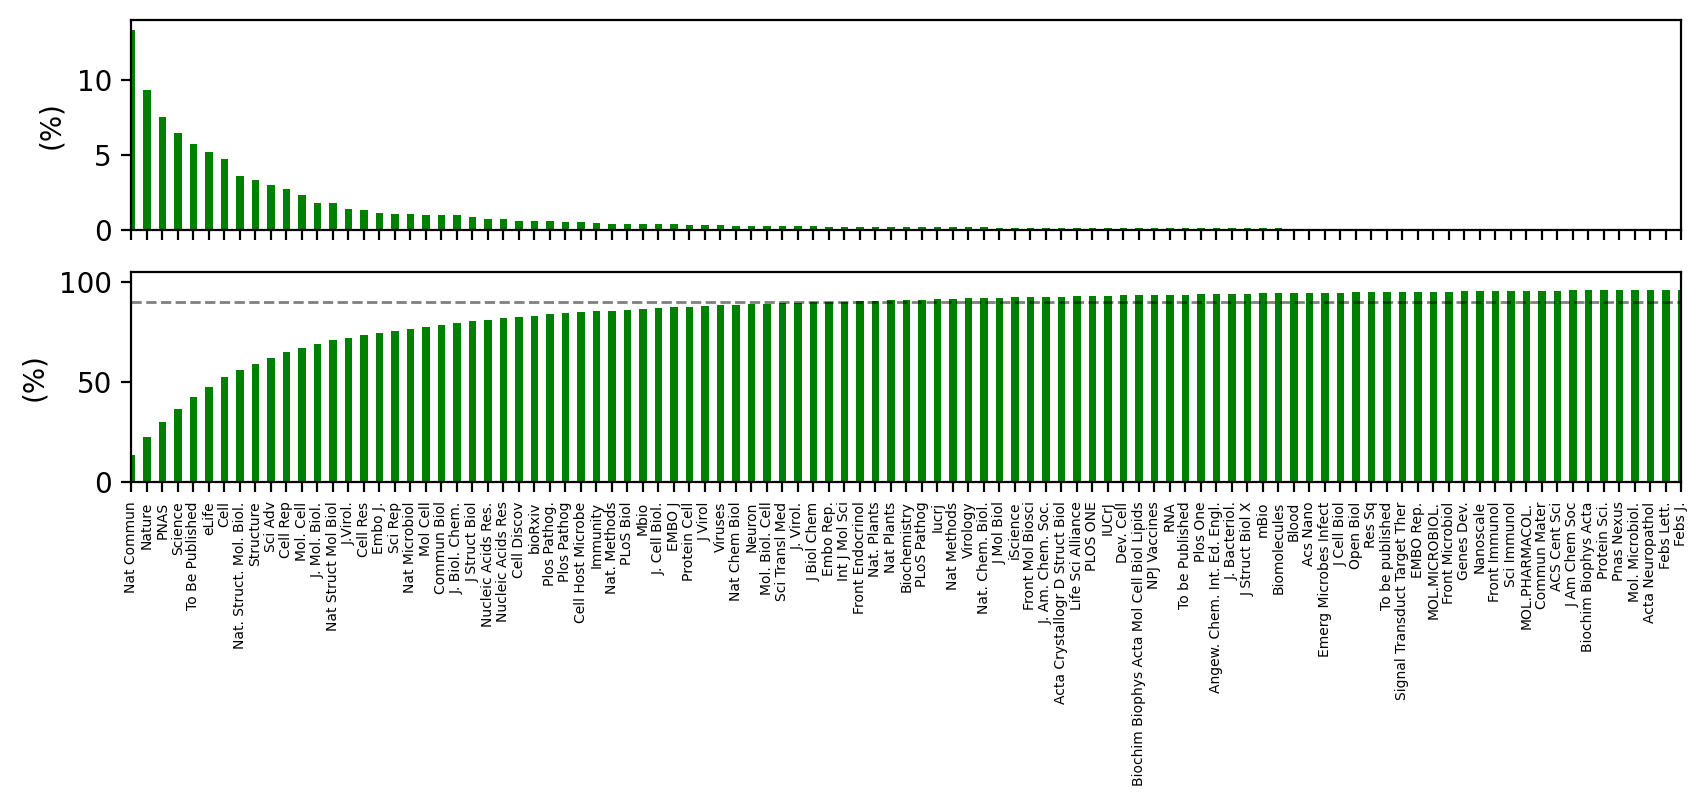

In [159]:
fig,axes = plt.subplots(2,1,figsize=(10,3),sharex=True,dpi=200)

X = df_journals['Name'].value_counts()
Y = 100*X/len(df_journals)

ax = axes[0]
Y.plot(kind='bar',
       color='green',
       ax=ax)

ax.set_ylabel('(%)')
ax.set_xlim(0,100)

ax = axes[1]
Y.cumsum().plot(kind='bar',
       color='green',
       ax=ax)

ax.set_ylabel('(%)')
ax.axhline(90,linestyle='--',color='black',lw=1, alpha=0.5)
ax.set_xlim(0,100)

plt.xticks(fontsize=5)

plt.show()